In [2]:
from copy import deepcopy as dc
import re
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Multiply, Dense, Dropout, Flatten, Bidirectional, Lambda
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential, backend
from keras.utils.vis_utils import plot_model

In [3]:
cleaned_data = pd.read_csv("/content/drive/MyDrive/Deep Learning Data /cleaned_data_without_stopwords.csv")
cleaned_data.tail()

,question1,question2,is_duplicate
404282,many keywords racket program language latest v...,many keywords perl program language latest ver...,0
404283,believe life death,true life death,1
404284,one coin,coin,0
404285,approx annual cost live study uic chicago indi...,little hairfall problem want use hair style pr...,0
404286,like sex cousin,like sex cousin,0


In [4]:
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(cleaned_data['question1'].values.astype(str))+list(cleaned_data['question2'].values.astype(str)))

X_train_q1 = tokenizer.texts_to_sequences(cleaned_data['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 54, padding='post')

X_train_q2 = tokenizer.texts_to_sequences(cleaned_data['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 54, padding='post')

In [5]:
word_index = tokenizer.word_index
Y_train = cleaned_data['is_duplicate'].values

In [6]:
embedding_index = {}
with open('/content/drive/MyDrive/Deep Learning Data /glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [7]:
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
with tf.device('/device:GPU:0'):
  lstm_layer = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  # loading our matrix
  emb = Embedding(input_dim = len(word_index)+1,
                          output_dim = 100,
                        weights = [embedding_matrix],
                        input_length = 54)
  input1 = Input(shape=(54,))
  e1 = emb(input1)
  x1 = lstm_layer(e1)
  input2 = Input(shape=(54,))
  e2 = emb(input2)
  x2 = lstm_layer(e2)
  mhd = lambda x: backend.abs(x[0] - x[1])
  merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
  preds = Dense(1, activation='sigmoid')(merged)
  model = Model(inputs=[input1, input2], outputs=preds)
  model.compile(loss='mse', optimizer='adam', metrics = ['accuracy'])

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
with tf.device('/device:GPU:0'):
  model.fit([X_train_q1,X_train_q2],Y_train, batch_size = 2000, epochs = 20)

Epoch 1/20
203/203 [==============================] - 243s 1s/step - loss: 0.1873 - accuracy: 0.7019
Epoch 2/20
203/203 [==============================] - 204s 1s/step - loss: 0.1546 - accuracy: 0.7679
Epoch 3/20
203/203 [==============================] - 203s 1s/step - loss: 0.1418 - accuracy: 0.7902
Epoch 4/20
203/203 [==============================] - 198s 975ms/step - loss: 0.1331 - accuracy: 0.8052
Epoch 5/20
203/203 [==============================] - 198s 971ms/step - loss: 0.1259 - accuracy: 0.8179
Epoch 6/20
203/203 [==============================] - 197s 971ms/step - loss: 0.1198 - accuracy: 0.8284
Epoch 7/20
203/203 [==============================] - 199s 981ms/step - loss: 0.1143 - accuracy: 0.8370
Epoch 8/20
203/203 [==============================] - 198s 972ms/step - loss: 0.1094 - accuracy: 0.8454
Epoch 9/20
203/203 [==============================] - 200s 984ms/step - loss: 0.1053 - accuracy: 0.8522
Epoch 10/20
203/203 [==============================] - 198s 974ms/step - 

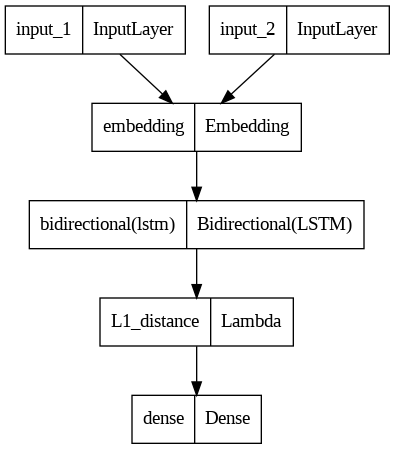

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [11]:
# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def expand_contractions(sentence):
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    # Create a regular expression pattern to match the contractions
    pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')

    # Function to replace the matched contractions with their expanded forms
    def replace(match):
        return contractions[match.group(0)]

    # Use the sub() function with the replace function to expand contractions
    expanded_sentence = re.sub(pattern, replace, sentence)

    return expanded_sentence

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token, 'v') for token in tokens]
    lemmatized_sentence = ' '.join(lemmatized_tokens)
    return lemmatized_sentence

def delete_stopwords(sentence):
    tokens = word_tokenize(sentence)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_tokens)
    return filtered_sentence

def text_cleaning(x):
    # To replace consecutive whitespace and newline characters with a single space character in the string
    q = re.sub('\s+\n+', ' ', x)
    
    # To lowercase
    q = q.lower()
    
    # expand contractions
    q = expand_contractions(q)
    
    # To replace any non-alphanumeric character in the string 
    q = re.sub('[^a-zA-Z0-9]', ' ', q)
    
    # Lemmatization
    q = lemmatize_sentence(q)
    
    return delete_stopwords(q)
    #return q

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
def predict(q1, q2):
  q1 = text_cleaning(q1)
  q2 = text_cleaning(q2)

  process_q1 = tokenizer.texts_to_sequences([q1])
  process_q1 = pad_sequences(process_q1, maxlen = 54, padding='post')

  process_q2 = tokenizer.texts_to_sequences([q2])
  process_q2 = pad_sequences(process_q2, maxlen = 54, padding='post')

  return str(model.predict([process_q1,process_q2])[0][0])

In [16]:
predict("Why are so many Quora users posting questions that are readily answered on Google?", "Why do people ask Quora questions which can be answered easily by Google?")

1/1 [==============================] - 0s 92ms/step


'0.86219984'

In [15]:
predict("Why are so many Quora users posting questions that are readily answered on Google?", "What is coin?")

1/1 [==============================] - 0s 175ms/step


'0.00022678396'